# Analysis

In this code, we load all of the results generated from each iteration of `LLM Testing.ipynb` in addition to the truth table derived from the ASRA-PM Coags App. We then calculate summary statistics on the results and generate the figures provided in the manuscript.

This code should run with relatively little setup.

In [1]:
import openai
import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

print(f'{pd.__version__=}, {np.__version__=}, {matplotlib.__version__=}')

pd.__version__='1.5.3', np.__version__='1.24.2', matplotlib.__version__='3.7.1'


In [2]:
from sklearn.metrics import RocCurveDisplay

In [3]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [4]:
def get_metrics(y_true, y_pred):
    # Assume y_true and y_pred are the true and predicted binary labels
    # for a set of test examples
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Extract true positive, false negative, false positive, and true negative counts
    tn, fp, fn, tp = cm.ravel()
    
    # Print metrics
    print(f'True positives: {tp}, False negatives: {fn}, False positives: {fp}, True negatives: {tn}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 score: {f1:.4f}')


In [5]:
df = pd.read_csv('results/truth_table.csv', index_col=0)
df = df.drop(columns=['Scenario Data'])

df


,Patient ID,asra_safe
0,AA,0
1,AB,1
2,AC,0
3,AD,0
4,AE,1
...,...,...
255,JV,1
256,JW,0
257,JX,1
258,JY,0


In [6]:
baseline = pd.read_csv('results/0_baseline.csv', index_col=0).reset_index()
gpt3 = pd.read_csv('results/1_gpt3.csv', index_col=0).reset_index()
gpt4 = pd.read_csv('results/2_gpt4.csv', index_col=0).reset_index()
gpt4corr = pd.read_csv('results/3_gpt4corr.csv', index_col=0).reset_index()
explicit = pd.read_csv('results/4_explicit.csv', index_col=0).reset_index()

In [7]:
for new_df, title in zip([baseline, gpt3, gpt4, gpt4corr, explicit], ['baseline', 'gpt3', 'gpt4', 'gpt4corr', 'explicit']):
    new_df
    
    # Merge the two dataframes on 'Patient ID'
    df = df.merge(new_df[['Patient ID', 'Safe Intervention']], on='Patient ID', how='left')
    
    # Rename 'Safe Intervention'
    df = df.rename(columns={'Safe Intervention': title})
    
df

,Patient ID,asra_safe,baseline,gpt3,gpt4,gpt4corr,explicit
0,AA,0,0.0,0.0,0.1,0.1,0.000000
1,AB,1,0.1,0.3,0.4,0.5,0.300000
2,AC,0,0.2,0.2,0.3,0.3,0.100000
3,AD,0,0.4,0.4,0.5,0.4,0.200000
4,AE,1,1.0,1.0,1.0,1.0,1.000000
...,...,...,...,...,...,...,...
255,JV,1,0.7,0.5,1.0,1.0,0.888889
256,JW,0,0.1,0.1,0.5,0.4,0.300000
257,JX,1,0.1,0.4,0.9,0.9,0.700000
258,JY,0,0.2,0.2,0.6,0.7,0.500000


In [8]:
df.columns

Index(['Patient ID', 'asra_safe', 'baseline', 'gpt3', 'gpt4', 'gpt4corr',
       'explicit'],
      dtype='object')

Summary statistics for Baseline:
True positives: 52, False negatives: 58, False positives: 54, True negatives: 96
Accuracy: 0.5692
Precision: 0.4906
Recall: 0.4727
F1 score: 0.4815
Summary statistics for Summary by GPT 3.5:
True positives: 44, False negatives: 66, False positives: 49, True negatives: 101
Accuracy: 0.5577
Precision: 0.4731
Recall: 0.4000
F1 score: 0.4335
Summary statistics for Summary by GPT 4:
True positives: 72, False negatives: 38, False positives: 66, True negatives: 84
Accuracy: 0.6000
Precision: 0.5217
Recall: 0.6545
F1 score: 0.5806
Summary statistics for Corrected Summary by GPT 4:
True positives: 75, False negatives: 35, False positives: 65, True negatives: 85
Accuracy: 0.6154
Precision: 0.5357
Recall: 0.6818
F1 score: 0.6000
Summary statistics for Explicit Answers in Prompt:
True positives: 72, False negatives: 38, False positives: 50, True negatives: 100
Accuracy: 0.6615
Precision: 0.5902
Recall: 0.6545
F1 score: 0.6207


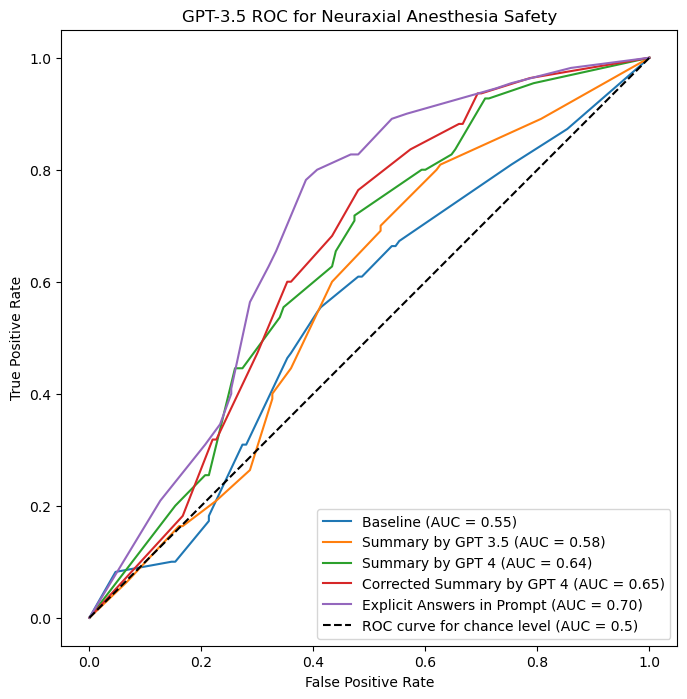

In [9]:
fig, ax = plt.subplots(figsize=(8,8))

temp_df = df[['Patient ID', 'asra_safe', 'baseline']].dropna()
name = 'Baseline'
RocCurveDisplay.from_predictions(
    y_true=temp_df.asra_safe,
    y_pred=temp_df.iloc[:,-1],
    name=name,
    ax=ax,
)
print(f'Summary statistics for {name}:')
get_metrics(temp_df.asra_safe > 0.5, temp_df.iloc[:,-1] > 0.5)

temp_df = df[['Patient ID', 'asra_safe', 'gpt3']].dropna()
name = 'Summary by GPT 3.5'
RocCurveDisplay.from_predictions(
    y_true=temp_df.asra_safe,
    y_pred=temp_df.iloc[:,-1],
    name=name,
    ax=ax,
)
print(f'Summary statistics for {name}:')
get_metrics(temp_df.asra_safe > 0.5, temp_df.iloc[:,-1] > 0.5)

temp_df = df[['Patient ID', 'asra_safe', 'gpt4']].dropna()
name = 'Summary by GPT 4'
RocCurveDisplay.from_predictions(
    y_true=temp_df.asra_safe,
    y_pred=temp_df.iloc[:,-1],
    name=name,
    ax=ax,
)
print(f'Summary statistics for {name}:')
get_metrics(temp_df.asra_safe > 0.5, temp_df.iloc[:,-1] > 0.5)

temp_df = df[['Patient ID', 'asra_safe', 'gpt4corr']].dropna()
name = 'Corrected Summary by GPT 4'
RocCurveDisplay.from_predictions(
    y_true=temp_df.asra_safe,
    y_pred=temp_df.iloc[:,-1],
    name=name,
    ax=ax,
)
print(f'Summary statistics for {name}:')
get_metrics(temp_df.asra_safe > 0.5, temp_df.iloc[:,-1] > 0.5)

temp_df = df[['Patient ID', 'asra_safe', 'explicit']].dropna()
name = 'Explicit Answers in Prompt'
RocCurveDisplay.from_predictions(
    y_true=temp_df.asra_safe,
    y_pred=temp_df.iloc[:,-1],
    name=name,
    ax=ax,
)
print(f'Summary statistics for {name}:')
get_metrics(temp_df.asra_safe > 0.5, temp_df.iloc[:,-1] > 0.5)

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("GPT-3.5 ROC for Neuraxial Anesthesia Safety")
plt.legend()
plt.show()

In [10]:
#df.to_csv('results/compiled_results.csv')

In [11]:
df = df[['Patient ID', 'asra_safe', 'baseline', 'gpt3',
       'gpt4', 'gpt4corr',
       'explicit']]

In [12]:
df

,Patient ID,asra_safe,baseline,gpt3,gpt4,gpt4corr,explicit
0,AA,0,0.0,0.0,0.1,0.1,0.000000
1,AB,1,0.1,0.3,0.4,0.5,0.300000
2,AC,0,0.2,0.2,0.3,0.3,0.100000
3,AD,0,0.4,0.4,0.5,0.4,0.200000
4,AE,1,1.0,1.0,1.0,1.0,1.000000
...,...,...,...,...,...,...,...
255,JV,1,0.7,0.5,1.0,1.0,0.888889
256,JW,0,0.1,0.1,0.5,0.4,0.300000
257,JX,1,0.1,0.4,0.9,0.9,0.700000
258,JY,0,0.2,0.2,0.6,0.7,0.500000


In [13]:
subtest = df.copy()
subtest.loc[:,'scenario'] = df['Patient ID'].str[1]
subtest

,Patient ID,asra_safe,baseline,gpt3,gpt4,gpt4corr,explicit,scenario
0,AA,0,0.0,0.0,0.1,0.1,0.000000,A
1,AB,1,0.1,0.3,0.4,0.5,0.300000,B
2,AC,0,0.2,0.2,0.3,0.3,0.100000,C
3,AD,0,0.4,0.4,0.5,0.4,0.200000,D
4,AE,1,1.0,1.0,1.0,1.0,1.000000,E
...,...,...,...,...,...,...,...,...
255,JV,1,0.7,0.5,1.0,1.0,0.888889,V
256,JW,0,0.1,0.1,0.5,0.4,0.300000,W
257,JX,1,0.1,0.4,0.9,0.9,0.700000,X
258,JY,0,0.2,0.2,0.6,0.7,0.500000,Y


In [14]:
# Define the grouping ranges as a list of tuples
group_ranges = [
    ('A', 'H'),
    ('I', 'K'),
    ('L', 'M'),
    ('N', 'Q'),
    ('R', 'S'),
    ('T', 'U'),
    ('V', 'X'),
    ('Y', 'Z')
]

# Map the group ranges to labels and create a new column with bins based on the ranges
group_labels = [f'{start}-{end}' for start, end in group_ranges]
bin_edges = [ord(start)-1 for start, end in group_ranges] + [ord('Z')+1]
subtest['Patient Group'] = pd.cut(subtest['Patient ID'].str[1].apply(ord), bins=bin_edges, labels=group_labels)

# Group the dataframe by the new column and create separate dataframes for each group
grouped = subtest.groupby('Patient Group')
groups = {name: group for name, group in grouped}

# Example usage: get the dataframe for patient group 'A-H'
heparin = groups['A-H']
lovenox = groups['I-K']
eliquis = groups['L-M']
warfarn = groups['N-Q']
#aspirin = groups['R-S'] #Invalid test for AUROC, as it is always safe
dabigat = groups['T-U']
rivarox = groups['V-X']
anti_plt = pd.concat([groups['R-S'], groups['Y-Z']])

In [15]:
df_list = [
    df,
    heparin,
    lovenox,
    eliquis,
    warfarn,
    dabigat,
    rivarox,
    anti_plt ,
]
name_list = [
    'All Results',
    'Heparin Only',
    'Enoxaparin Only',
    'Apixaban Only',
    'Warfarin Only',
    'Dabigatran Only',
    'Rivaroxaban Only',
    'Antiplatelets Only', 
]

Summary statistics for Baseline:
Summary statistics for Summary by GPT 3.5:
Summary statistics for Summary by GPT 4:
Summary statistics for Corrected Summary by GPT 4:
Summary statistics for Explicit Answers in Prompt:


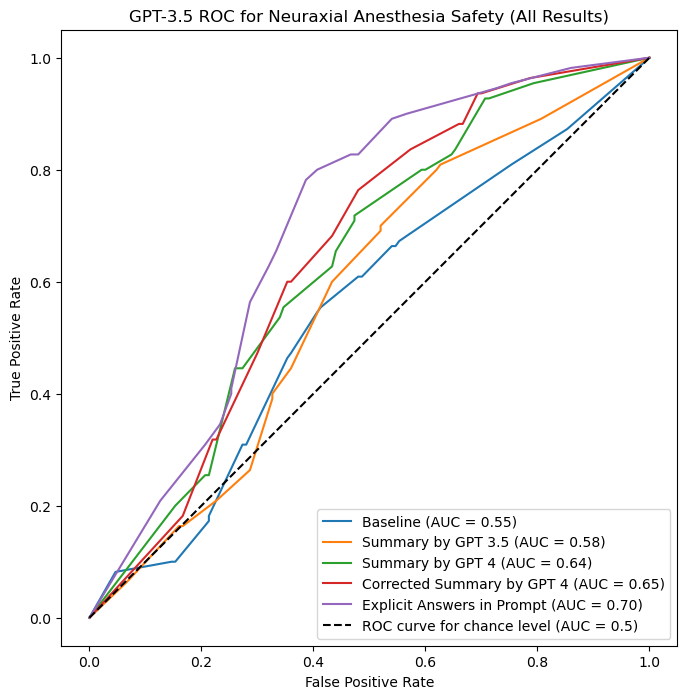

Summary statistics for Baseline:
Summary statistics for Summary by GPT 3.5:
Summary statistics for Summary by GPT 4:
Summary statistics for Corrected Summary by GPT 4:
Summary statistics for Explicit Answers in Prompt:


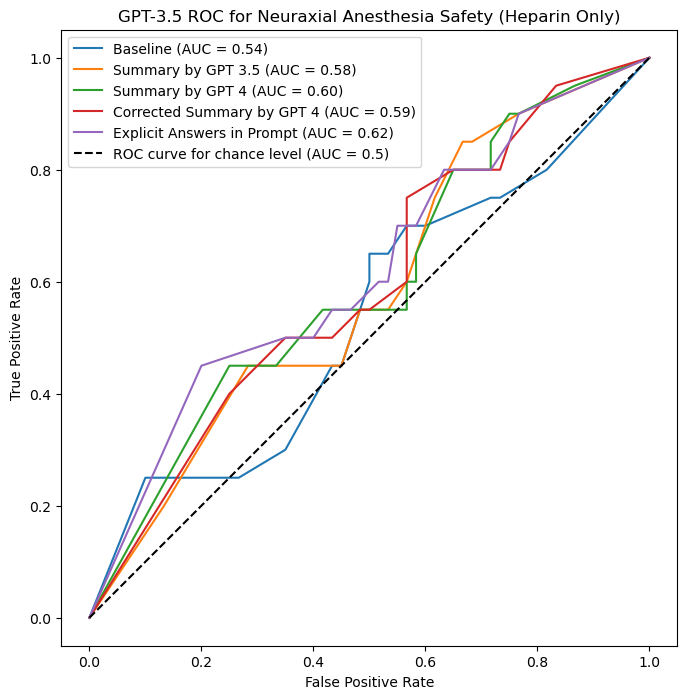

Summary statistics for Baseline:
Summary statistics for Summary by GPT 3.5:
Summary statistics for Summary by GPT 4:
Summary statistics for Corrected Summary by GPT 4:
Summary statistics for Explicit Answers in Prompt:


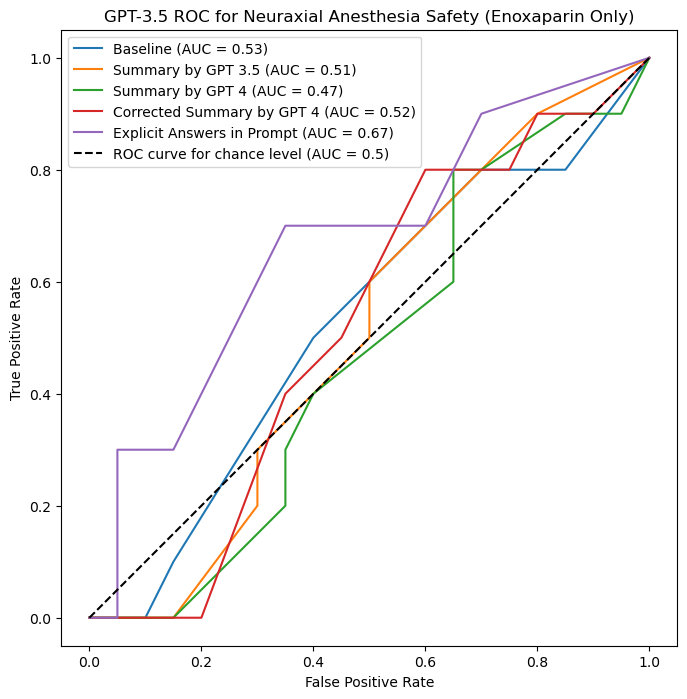

Summary statistics for Baseline:
Summary statistics for Summary by GPT 3.5:
Summary statistics for Summary by GPT 4:
Summary statistics for Corrected Summary by GPT 4:
Summary statistics for Explicit Answers in Prompt:


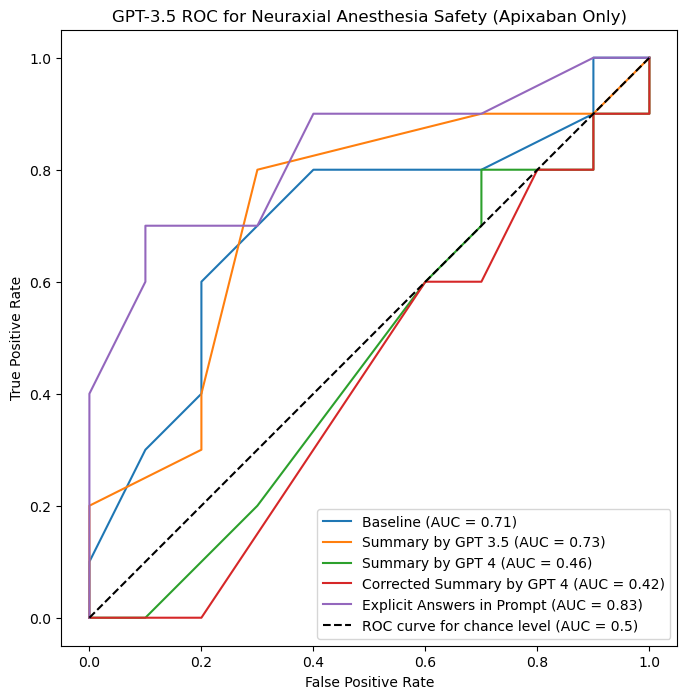

Summary statistics for Baseline:
Summary statistics for Summary by GPT 3.5:
Summary statistics for Summary by GPT 4:
Summary statistics for Corrected Summary by GPT 4:
Summary statistics for Explicit Answers in Prompt:


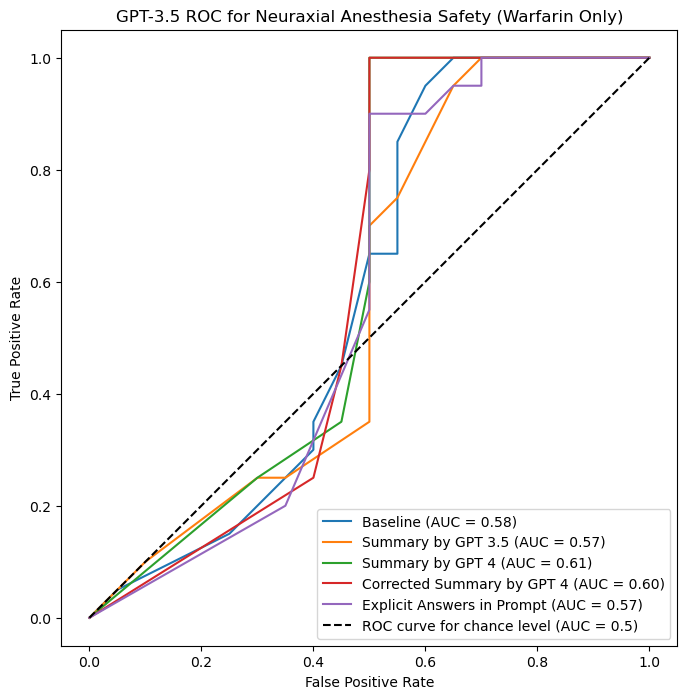

Summary statistics for Baseline:
Summary statistics for Summary by GPT 3.5:
Summary statistics for Summary by GPT 4:
Summary statistics for Corrected Summary by GPT 4:
Summary statistics for Explicit Answers in Prompt:


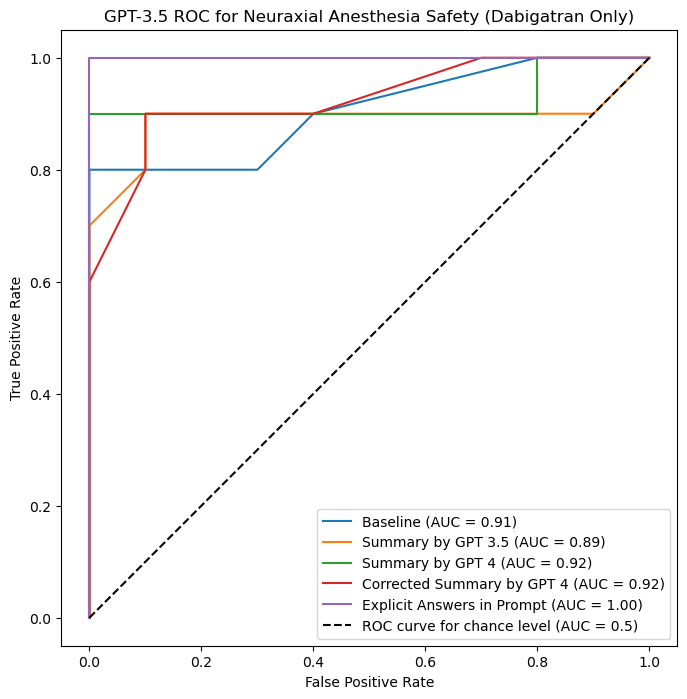

Summary statistics for Baseline:
Summary statistics for Summary by GPT 3.5:
Summary statistics for Summary by GPT 4:
Summary statistics for Corrected Summary by GPT 4:
Summary statistics for Explicit Answers in Prompt:


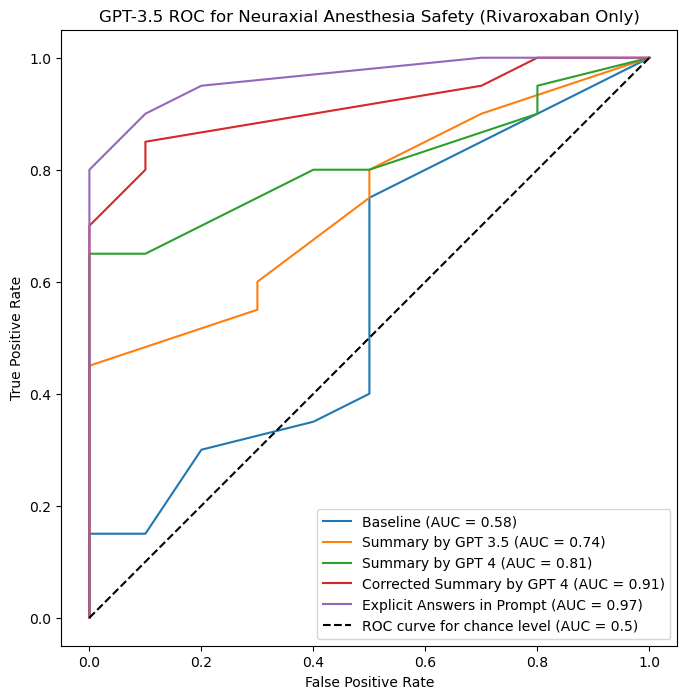

Summary statistics for Baseline:
Summary statistics for Summary by GPT 3.5:
Summary statistics for Summary by GPT 4:
Summary statistics for Corrected Summary by GPT 4:
Summary statistics for Explicit Answers in Prompt:


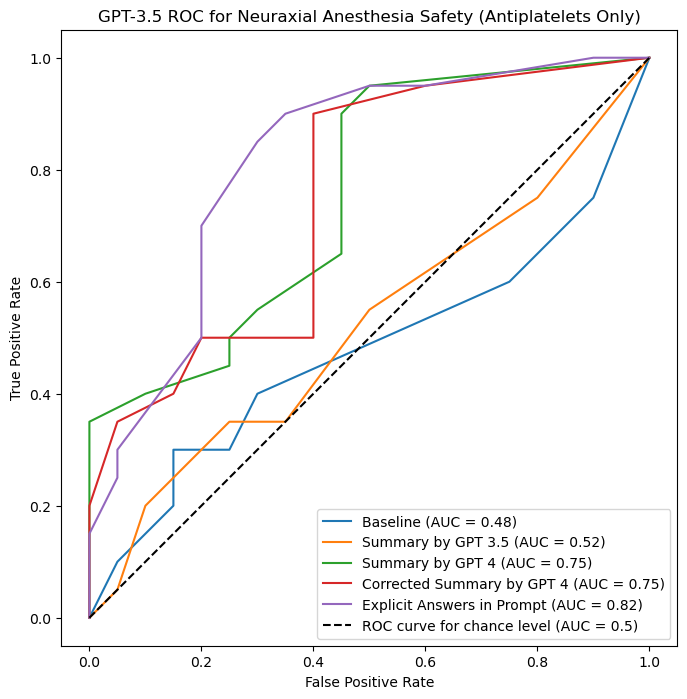

In [16]:
for sub_df, drug in zip(df_list, name_list):
    fig, ax = plt.subplots(figsize=(8,8))
    
    temp_df = sub_df[['Patient ID', 'asra_safe', 'baseline']].dropna()
    name = 'Baseline'
    RocCurveDisplay.from_predictions(
        y_true=temp_df.asra_safe,
        y_pred=temp_df.iloc[:,-1],
        name=name,
        ax=ax,
    )
    print(f'Summary statistics for {name}:')
    
    temp_df = sub_df[['Patient ID', 'asra_safe', 'gpt3']].dropna()
    name = 'Summary by GPT 3.5'
    RocCurveDisplay.from_predictions(
        y_true=temp_df.asra_safe,
        y_pred=temp_df.iloc[:,-1],
        name=name,
        ax=ax,
    )
    print(f'Summary statistics for {name}:')
    
    temp_df = sub_df[['Patient ID', 'asra_safe', 'gpt4']].dropna()
    name = 'Summary by GPT 4'
    RocCurveDisplay.from_predictions(
        y_true=temp_df.asra_safe,
        y_pred=temp_df.iloc[:,-1],
        name=name,
        ax=ax,
    )
    print(f'Summary statistics for {name}:')
    
    temp_df = sub_df[['Patient ID', 'asra_safe', 'gpt4corr']].dropna()
    name = 'Corrected Summary by GPT 4'
    RocCurveDisplay.from_predictions(
        y_true=temp_df.asra_safe,
        y_pred=temp_df.iloc[:,-1],
        name=name,
        ax=ax,
    )
    print(f'Summary statistics for {name}:')
    
    temp_df = sub_df[['Patient ID', 'asra_safe', 'explicit']].dropna()
    name = 'Explicit Answers in Prompt'
    RocCurveDisplay.from_predictions(
        y_true=temp_df.asra_safe,
        y_pred=temp_df.iloc[:,-1],
        name=name,
        ax=ax,
    )
    print(f'Summary statistics for {name}:')
    
    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"GPT-3.5 ROC for Neuraxial Anesthesia Safety ({drug})")
    plt.legend()
    plt.show()